In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random
import os

from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed

import warnings

In [3]:
IMG_SIZE = 160
BATCH = 70

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(42)

SEED = 42

warnings.filterwarnings('ignore')


main_path = "/content/drive/MyDrive/chest_xray/chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

Examples - Normal


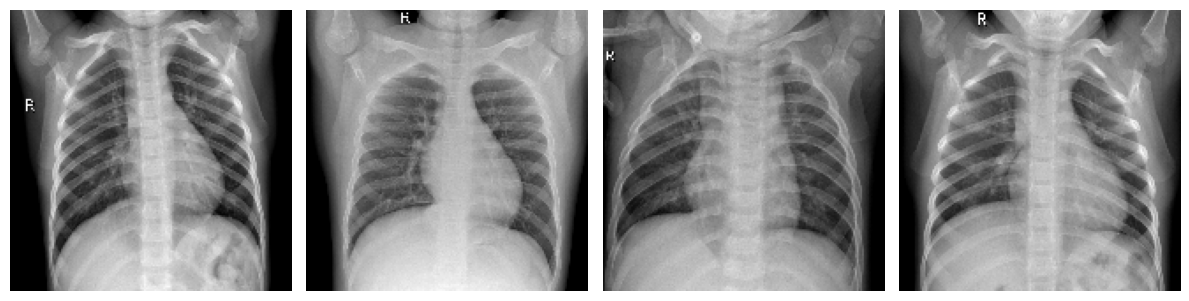

In [6]:
print('Examples - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 4):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Exemples - Pneumonia


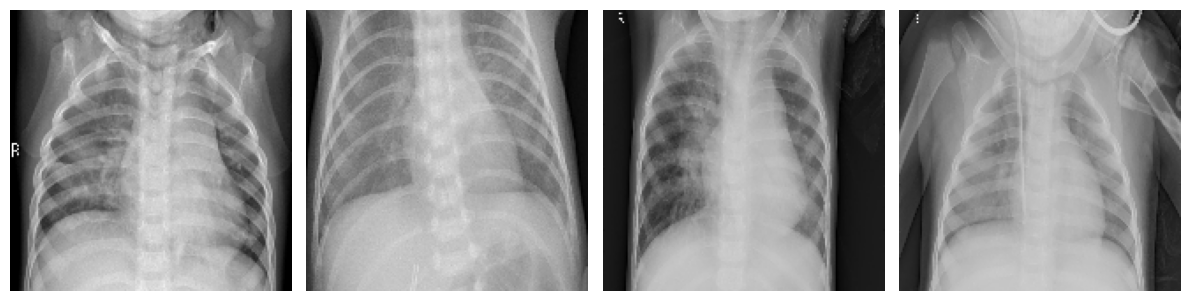

In [7]:
print('Exemples - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 4):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [8]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [11]:
from keras.applications.resnet50 import ResNet50

In [12]:
base_model = ResNet50(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():


    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)


    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)

    return model

keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(), metrics='binary_accuracy')

model_pretrained.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [13]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 70,
          validation_data=ds_val,
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/70
59/59 [==============================] - 2141s 36s/step - loss: 0.5719 - binary_accuracy: 0.7366 - val_loss: 0.5577 - val_binary_accuracy: 0.7433
Epoch 2/70
59/59 [==============================] - 88s 1s/step - loss: 0.5381 - binary_accuracy: 0.7421 - val_loss: 0.5146 - val_binary_accuracy: 0.7433
Epoch 3/70
59/59 [==============================] - 88s 1s/step - loss: 0.5086 - binary_accuracy: 0.7464 - val_loss: 0.5011 - val_binary_accuracy: 0.7557
Epoch 4/70
59/59 [==============================] - 87s 1s/step - loss: 0.4782 - binary_accuracy: 0.7581 - val_loss: 0.4575 - val_binary_accuracy: 0.7462
Epoch 5/70
59/59 [==============================] - 86s 1s/step - loss: 0.4497 - binary_accuracy: 0.7713 - val_loss: 0.4306 - val_binary_accuracy: 0.7701
Epoch 6/70
59/59 [==============================] - 86s 1s/step - loss: 0.4339 - binary_accuracy: 0.7800 - val_loss: 0.4113 - val_binary_accuracy: 0.7912
Epoch 7/70
59/59 [==============================] - 86s 1s/step - loss: 0

In [14]:
# Save the model
model_pretrained.save('finalmodel-ResNet50.hdf5')


In [24]:
# Save the model to a specific directory
model_pretrained.save('C:\project/finalmodel-ResNet50.hdf5')

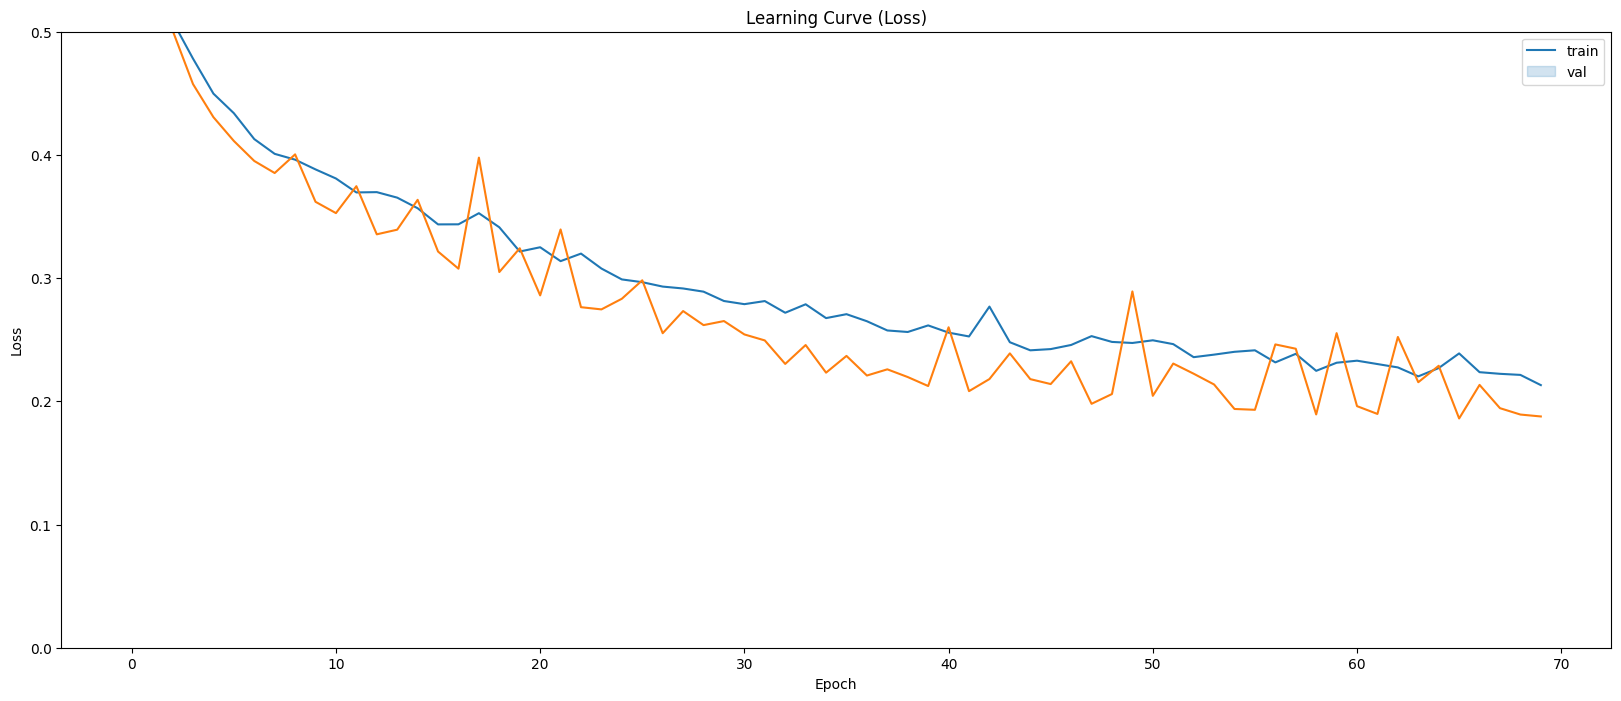

In [25]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

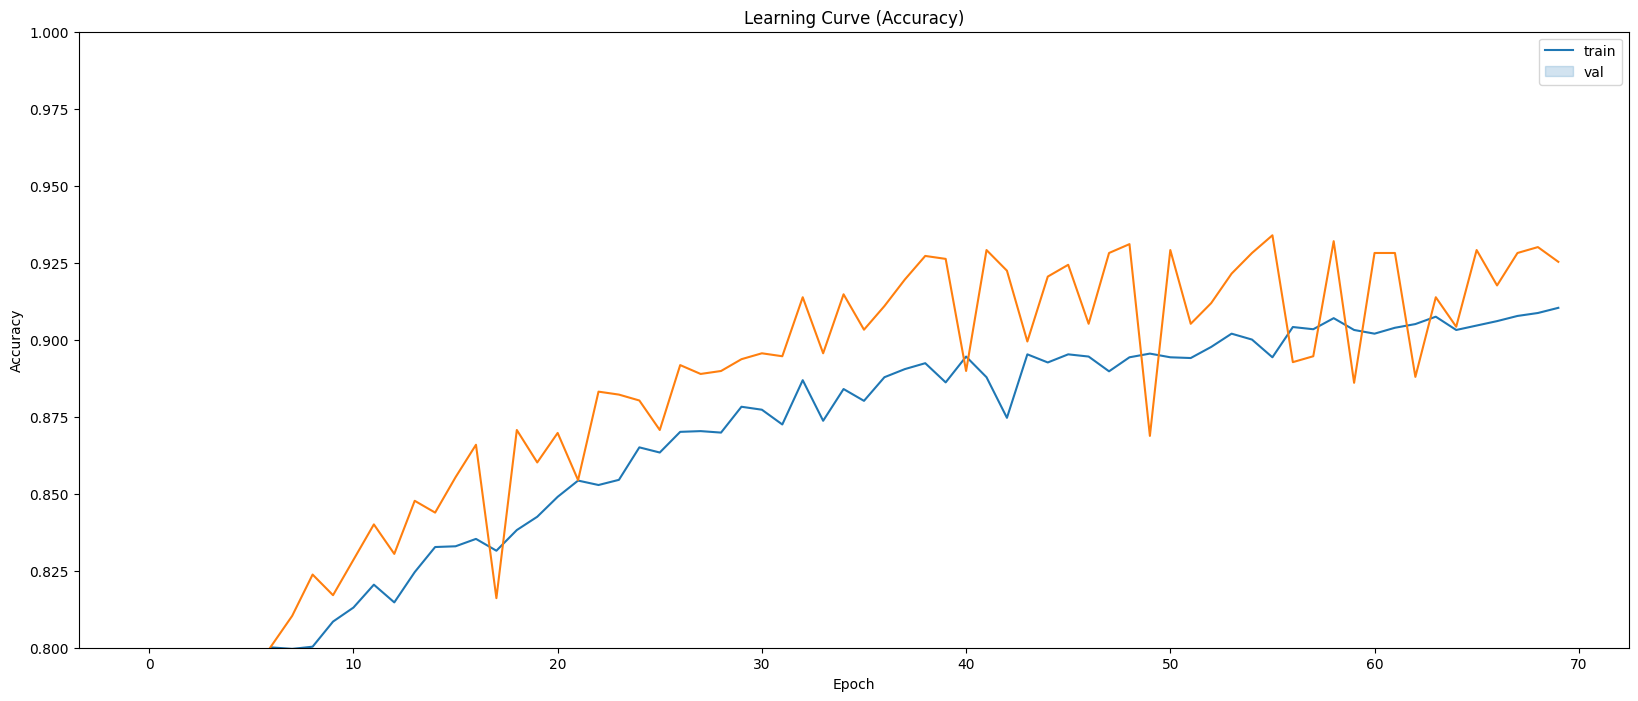

In [26]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [27]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1877124309539795
Val accuracy: 0.9252873659133911


In [18]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5948548316955566
Test accuracy: 0.7612179517745972


In [28]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.7612179487179487


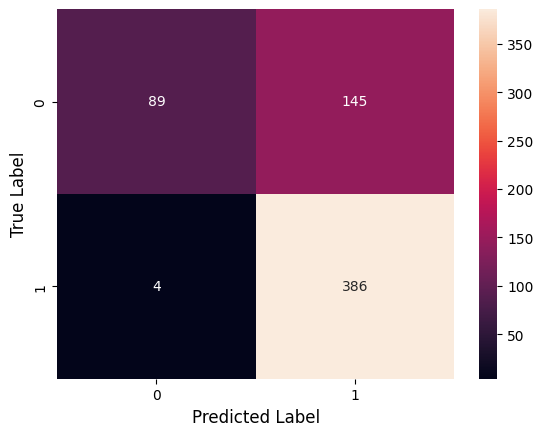

In [29]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [30]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.96      0.38      0.54       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.69      0.69       624
weighted avg       0.81      0.76      0.73       624



In [34]:
!apt-get install -qq git

In [ ]:
from getpass import getpass
import os
os.environ['Asifkletech'] = getpass('Asifkletech')
os.environ['GITHUB_TOKEN'] = getpass('GitHub token:')